<a href="https://colab.research.google.com/github/hasylle/sentimentanalysisLSTM/blob/master/SentimentAnalysisIMDBWord2VecLSTM(Colab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bag of Words meets Bag of Popcorn
A Kaggle Competition using Google's Word2Vec for movie reviews

# Data Set
The labeled data set consists of 50,000 IMDB movie reviews, specially selected for sentiment analysis. The sentiment of reviews is binary, meaning the IMDB rating < 5 results in a sentiment score of 0, and rating >=7 have a sentiment score of 1. No individual movie has more than 30 reviews. The 25,000 review labeled training set does not include any of the same movies as the 25,000 review test set. In addition, there are another 50,000 IMDB reviews provided without any rating labels.

To train the word2vec, we use all available data sets and combine to form a big corpus. Also, to increase our accuracy, we use an additional augmented dataset with a total of 49,912 reviews which also contains the original 25,000 train data set.

First, we should make sure that no entry in the test data set is in the augmented data set. This is confirmed by the code below: 

In [0]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Colab Notebooks"
testdf = pd.read_csv('/content/drive/My Drive/Colab Notebooks/testData.tsv',sep="\t")
traindf = pd.read_csv('/content/drive/My Drive/Colab Notebooks/augmented_traindata_clean2.csv')
print(traindf.info())
mergedf = pd.merge(testdf,traindf,on=['review'],how='inner')
print(mergedf.info())
print(mergedf.head())

Mounted at /content/drive
 augmented_traindata_clean2.csv
 cnn_cifar10.ipynb
 imdb_master.csv
 labeledTrainData.tsv
'mlp_cifar10 (1).ipynb'
 mlp_cifar10.ipynb
 SentimentAnalysisIMDBCBOWLSTM.ipynb
 SentimentAnalysisIMDB.ipynb
 SentimentAnalysisIMDBWord2VecBiLSTM.ipynb
 testData.tsv
 unlabeledTrainData.tsv
 Untitled0.ipynb
 Untitled1.ipynb
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49912 entries, 0 to 49911
Data columns (total 3 columns):
sentiment    49912 non-null int64
review       49912 non-null object
type         49912 non-null object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 4 columns):
id           0 non-null object
review       0 non-null object
sentiment    0 non-null int64
type         0 non-null object
dtypes: int64(1), object(3)
memory usage: 0.0+ bytes
None
Empty DataFrame
Columns: [id, review, sentiment, type]
Index: []


Next, we combine all the datasets into one review corpus which we'll use only for the Word2vec model. 

In [0]:
import pandas as pd
pd.options.display.max_colwidth = 100
filepath = '/content/drive/My Drive/Colab Notebooks/'
traindf=[]
traindf = pd.read_csv(filepath+'augmented_traindata_clean2.csv')
#traindf = traindf.drop(['id'], axis=1)
traindf['type'] = 'train'
addtldf=[]
addtldf = pd.read_csv(filepath+'unlabeledTrainData.tsv',error_bad_lines=False,delimiter="\t")
addtldf = addtldf.drop(['id'], axis=1)
addtldf['type'] = 'addtl'
test=[]
test = pd.read_csv(filepath+'testData.tsv',delimiter="\t")
test['type'] = 'test'
revcorpus = pd.concat([traindf,addtldf,test],ignore_index=True,sort=False)
print("Number of reviews: ",len(revcorpus))


b'Skipping line 43043: expected 2 fields, saw 3\n'


Number of reviews:  124910


# Data Preprocessing
We perform data cleaning on the reviews by removing tags, removing stopwords, lemmatization, and so on. 

In [0]:
import re
import string
# import the inflect library 
import inflect 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import PorterStemmer 
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams,bigrams
from nltk.tokenize import sent_tokenize
from nltk import download,set_proxy
download('punkt')
download('stopwords')
download('wordnet')
stemmer = PorterStemmer() 
p = inflect.engine() 
stop_words = set(stopwords.words("english")) 
# extract pure text from html
def remove_tags(text):
    try:
        text = re.sub(r'<[^<>]+>', " ", text)
    except:
        print(text)
    return text
# remove stopwords function 
def remove_stopwords(text): 
    word_tokens = word_tokenize(text) 
    filtered_text = [word for word in word_tokens if word not in stop_words] 
    filtered_text = " ".join(filtered_text)
    return filtered_text 

def text_lowercase(text): 
    return text.lower() 
  
# convert number into words 
def convert_number(text): 
    # split string into list of words 
    temp_str = text.split() 
    # initialise empty list 
    new_string = [] 
  
    for word in temp_str: 
        # if word is a digit, convert the digit 
        # to numbers and append into the new_string list 
        if word.isdigit(): 
            temp = p.number_to_words(word) 
            new_string.append(temp) 
  
        # append the word as it is 
        else: 
            new_string.append(word) 
  
    # join the words of new_string to form a string 
    temp_str = ' '.join(new_string) 
    return temp_str

# remove punctuation 
def remove_punctuation(text): 
    translator = str.maketrans('', '', string.punctuation) 
    return text.translate(translator)

    
# remove whitespace from text 
def remove_whitespace(text): 
    return  " ".join(text.split()) 

lemmatizer = WordNetLemmatizer() 
# lemmatize string 
def lemmatize_word(text): 
    word_tokens = word_tokenize(text) 
    # provide context i.e. part-of-speech 
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens] 
    #lemmas = " ".join(lemmas)
    return lemmas 
# stem words in the list of tokenised words 
def stem_words(text): 
    word_tokens = word_tokenize(text) 
    stems = [stemmer.stem(word) for word in word_tokens] 
    #stems = " ".join(stems)
    return stems 

def generate_ngram(text,n):
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    tokens = word_tokenize(text) 
    output = list(ngrams(tokens, n))
    #output = bigrams(tokens)
    return output

def preprocess_text(text):
    text = remove_tags(text)
    text = convert_number(text)
    text = text_lowercase(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = remove_whitespace(text)
    #text = stem_words(text)
    #text = ngram_vector(text)
    #print(text)
    text = lemmatize_word(text)
    #text = stem_words(text)
    return text
#revcorpus = revcorpus[1:5]
revcorpus['processed_review'] = revcorpus.review.apply(lambda x: preprocess_text(x))  
#revcorpus['bigrams'] = revcorpus.processed_review.apply(lambda x:generate_ngram(x,2))
print("Number of reviews: ",len(revcorpus))
#print(revcorpus.head(3))
#traindf['processed_review'] = traindf.review.apply(lambda x: preprocess_text(x))  
#print("Number of reviews: ",len(traindf))
#traindf.head(3)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Number of reviews:  124910


In [0]:
%%time
from gensim.models import Phrases
from gensim.models.phrases import Phraser
reviews = revcorpus['processed_review']
reviews.head()
bigrams = Phrases(sentences=reviews)
trigrams = Phrases(sentences=bigrams[reviews])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 2min 15s, sys: 477 ms, total: 2min 16s
Wall time: 2min 16s


In [0]:
print(bigrams[reviews][2])
print(trigrams[bigrams[reviews]][2])

['must', 'assume', 'praise', 'film', 'greatest', 'film', 'opera', 'ever', 'didnt', 'read_somewhere', 'either', 'dont_care', 'opera', 'dont_care', 'wagner', 'dont_care', 'anything', 'except', 'desire', 'appear', 'culture', 'either', 'representation', 'wagners', 'swansong', 'movie', 'strike', 'unmitigated_disaster', 'leaden', 'read', 'score', 'match', 'tricksy', 'lugubrious', 'realisation', 'text', 'questionable', 'people', 'ideas', 'opera', 'matter', 'play', 'especially', 'one', 'shakespeare', 'allow', 'anywhere_near', 'theatre', 'film', 'studio', 'syberberg', 'fashionably', 'without', 'smallest', 'justification', 'wagners', 'text', 'decide', 'parsifal', 'bisexual', 'integration', 'title', 'character', 'latter_stag', 'transmute', 'kind', 'beatnik', 'babe', 'though', 'one', 'continue', 'sing', 'high', 'tenor', 'actors', 'film', 'singers', 'get', 'double_dose', 'armin_jordan', 'conductor', 'see', 'face', 'hear', 'voice', 'amfortas', 'also', 'appear', 'monstrously', 'double_exposure', 'kin

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [0]:
%%time
#Word2Vec MODEL
from gensim.models import Word2Vec
embedding_vector_size = 200
#tokens = word_tokenize(bigrams[revcorpus['processed_review']])
wordvec_model = Word2Vec(
    sentences = bigrams[reviews],
    size = embedding_vector_size,
    min_count=3, window=5, workers=4)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 14min 57s, sys: 1.63 s, total: 14min 59s
Wall time: 10min 29s


In [0]:
pd.options.display.max_colwidth = 100
print("Vocabulary size:", len(wordvec_model.wv.vocab))
print("Number of reviews: ",len(traindf))
#for word in wordvec_model.wv.vocab:
#    print((word, wordvec_model.wv.vocab[word].count))
wordvec_model.wv.most_similar("great")

Vocabulary size: 122982
Number of reviews:  49912


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('fantastic', 0.6986942291259766),
 ('terrific', 0.6745198965072632),
 ('excellent', 0.6735690236091614),
 ('wonderful', 0.669349193572998),
 ('top_notch', 0.6072121262550354),
 ('awesome', 0.6037535071372986),
 ('superb', 0.5867407321929932),
 ('fabulous', 0.5849272608757019),
 ('brilliant', 0.5778151750564575),
 ('tremendous', 0.5561492443084717)]

In [0]:
train_reviews = revcorpus[revcorpus['type']=="train"]["processed_review"]
train_reviews = bigrams[train_reviews]
#train_reviews = [" ".join(text) for text in [review for review in train_reviews]]
print(len(train_reviews))

49912


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [0]:
# train_reviews[1]

### Vectorization 
Converting the words to vectors (Code grabbed from https://www.kaggle.com/alexcherniuk/imdb-review-word2vec-bilstm-99-acc)

In [0]:
%%time
from keras.preprocessing.sequence import pad_sequences
def vectorize_data(data, vocab: dict) -> list:
    print('Vectorize sentences...', end='\r')
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    print('Vectorize sentences... (done)')
    return vectorized
embed_size = 150
X_pad = pad_sequences(
    sequences=vectorize_data(train_reviews, vocab=wordvec_model.wv.vocab),
    maxlen=embed_size,
    padding='post')

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Vectorize sentences... (done)
CPU times: user 13min 18s, sys: 281 ms, total: 13min 19s
Wall time: 13min 20s


In [0]:
X_pad[1]

array([137, 138, 139, 140, 118, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 126, 107, 152,  51, 153, 154, 155, 156, 157, 158,
       159, 124, 160, 161, 162, 163,  59, 164, 165, 159, 166, 167, 168,
       169, 170, 104, 171, 172,  85, 173, 174, 175, 176, 103, 177,   4,
       118,  81, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
       189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
       202,   4, 203, 204, 205, 206, 207, 208, 209, 210, 211, 200,  39,
       212, 213, 214, 215, 216, 217, 218, 219, 220], dtype=int32)

In [0]:
y = revcorpus[revcorpus['type']=="train"]['sentiment']
#y = traindf['sentiment']

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, shuffle=False)
X_test

array([[  828,   953,  3970, ...,     0,     0,     0],
       [ 5062,  2626,  1375, ...,     0,     0,     0],
       [ 2594,   199,   897, ...,  1245,  3481,    33],
       ...,
       [  722,    42,  1881, ...,   176,   726, 17068],
       [  691,  2678,   752, ...,     0,     0,     0],
       [ 7348, 24292,   205, ...,     0,     0,     0]], dtype=int32)

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 150, 200)          24596400  
_________________________________________________________________
cu_dnnlstm_20 (CuDNNLSTM)    (None, 128)               168960    
_________________________________________________________________
dropout_68 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_69 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 1)                 65        
Total params: 24,773,681
Trainable params: 24,773,681
Non-trainable params: 0
_________________________________________

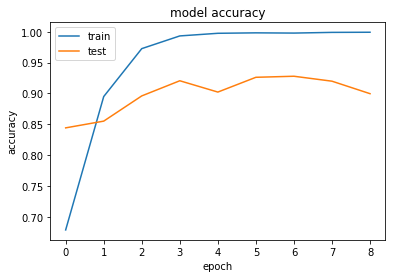

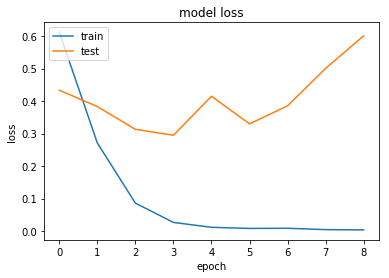

9983/9983 [==============================] - 1s 134us/step

Test accuracy: 92.8%


In [0]:
# EMBEDDING -> LSTM -> Dropout -> DENSE(RELU) -> DENSE(SIGMOID)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten,CuDNNLSTM, CuDNNGRU
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

#embed_size = 150
model = Sequential()
model.add(Embedding(input_dim=wordvec_model.wv.vectors.shape[0],output_dim=wordvec_model.wv.vectors.shape[1],weights=[wordvec_model.wv.vectors], input_length=embed_size,trainable=True))
#model.add(Embedding(max_features,embed_size))
model.add(CuDNNLSTM(128))
#model.add(GlobalMaxPool1D())
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
model.summary()
batch_size = 100
epochs = 20
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

es = callbacks.EarlyStopping(monitor='val_acc',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto',restore_best_weights=True)
history = model.fit(X_train,y_train, validation_data=(X_test,y_test),batch_size=batch_size, epochs=epochs, callbacks=[es])
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 150, 200)          24596400  
_________________________________________________________________
cu_dnngru_15 (CuDNNGRU)      (None, 128)               126720    
_________________________________________________________________
dropout_70 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 20)                2580      
_________________________________________________________________
dropout_71 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 21        
Total params: 24,725,721
Trainable params: 24,725,721
Non-trainable params: 0
_________________________________________

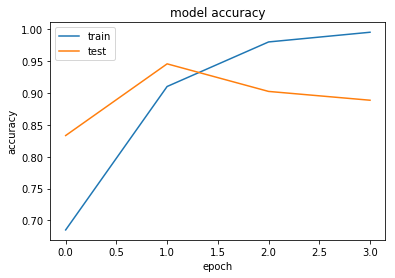

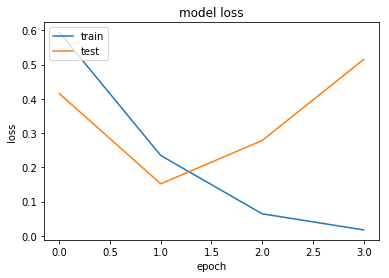

9983/9983 [==============================] - 1s 117us/step

Test accuracy: 94.6%


In [0]:
# EMBEDDING -> GRU -> Dropout -> DENSE(RELU) -> DENSE(SIGMOID)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten,CuDNNLSTM, CuDNNGRU
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks

#embed_size = 150
model = Sequential()
model.add(Embedding(input_dim=wordvec_model.wv.vectors.shape[0],output_dim=wordvec_model.wv.vectors.shape[1],weights=[wordvec_model.wv.vectors], input_length=embed_size,trainable=True))
#model.add(Embedding(max_features,embed_size))
model.add(CuDNNGRU(128))
#model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(20,activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))
model.summary()
batch_size = 100
epochs = 20
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = callbacks.EarlyStopping(monitor='val_acc',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto',restore_best_weights=True)
history = model.fit(X_train,y_train, validation_data=(X_test,y_test),batch_size=batch_size, epochs=epochs, callbacks=[es])
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 150, 300)          24795600  
_________________________________________________________________
cu_dnnlstm_13 (CuDNNLSTM)    (None, 128)               220160    
_________________________________________________________________
dropout_53 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_54 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 65        
Total params: 25,024,081
Trainable params: 25,024,081
Non-trainable params: 0
_________________________________________

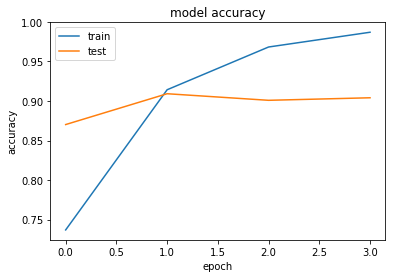

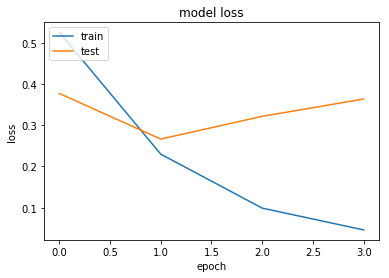

9983/9983 [==============================] - 1s 149us/step

Test accuracy: 90.9%


In [0]:
# EMBEDDING -> LSTM -> Dropout -> DENSE(RELU) -> DROPOUT -> DENSE(SIGMOID)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten,CuDNNLSTM, CuDNNGRU
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks

embed_size = 150
model = Sequential()
model.add(Embedding(input_dim=wordvec_model.wv.vectors.shape[0],output_dim=wordvec_model.wv.vectors.shape[1],weights=[wordvec_model.wv.vectors], input_length=embed_size,trainable=True))
model.add(CuDNNLSTM(128))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.summary()
batch_size = 100
epochs = 20
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = callbacks.EarlyStopping(monitor='val_acc',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto',restore_best_weights=True)
history = model.fit(X_train,y_train, validation_data=(X_test,y_test),batch_size=batch_size, epochs=epochs, callbacks=[es])
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

In [0]:
imdb=pd.read_csv(filepath+"imdb_master.csv",encoding="latin-1")
imdb = imdb[imdb.type=="test"]
imdb['label'] = imdb['label'].map({'neg':0,'pos':1})
imdb['processed_review'] = imdb.review.apply(lambda x: preprocess_text(x))  

print(imdb.info())
imdb.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 24999
Data columns (total 6 columns):
Unnamed: 0          25000 non-null int64
type                25000 non-null object
review              25000 non-null object
label               25000 non-null int64
file                25000 non-null object
processed_review    25000 non-null object
dtypes: int64(2), object(4)
memory usage: 1.3+ MB
None


,Unnamed: 0,type,review,label,file,processed_review
0,0,test,Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the ter...,0,0_2.txt,"[mr, costner, drag, movie, far, longer, necessary, aside, terrific, sea, rescue, sequence, care,..."
1,1,test,"This is an example of why the majority of action films are the same. Generic and boring, there's...",0,10000_4.txt,"[example, majority, action, film, generic, bore, theres, really, nothing, worth, watch, complete..."
2,2,test,"First of all I hate those moronic rappers, who could'nt act if they had a gun pressed against th...",0,10001_1.txt,"[first, hate, moronic, rappers, couldnt, act, gun, press, foreheads, curse, shoot, act, like, cl..."


In [131]:
X_test2 = pad_sequences(
    sequences=vectorize_data(bigrams[imdb['processed_review']], vocab=wordvec_model.wv.vocab),
    maxlen=embed_size,
    padding='post')

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Vectorize sentences... (done)


In [0]:
y_test2 = imdb['label']

In [133]:
loss, acc = model.evaluate(X_test2, y_test2, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

25000/25000 [==============================] - 3s 125us/step

Test accuracy: 93.4%


In [139]:
#SUBMISSION DATA
subdf = pd.read_csv(filepath+'testData.tsv',sep='\t')
subdf['processed_review'] = subdf.review.apply(lambda x: preprocess_text(x))  
X_sub = pad_sequences(
    sequences=vectorize_data(bigrams[subdf['processed_review']], vocab=wordvec_model.wv.vocab),
    maxlen=embed_size,
    padding='post')
Y_sub = model.predict_classes(X_sub)
subdf['sentiment'] = Y_sub
subdf.to_csv(filepath+'submission.csv',columns=['id','sentiment'],index=False)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Vectorize sentences... (done)


In [138]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
